In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [2]:
sdss_data = pd.read_csv("../input/tables/DATA7901_DR19.csv")

print(sdss_data.head())

                 objid          ra       dec    Column1   Column2           l  \
0  1237650760246886594  188.787929 -3.597081  188.78792 -3.597089  295.018068   
1  1237650760247017611  189.004019 -3.612495  189.00397 -3.612426  295.437733   
2  1237650760247476378  190.024317 -3.721682  190.02431 -3.721697  297.427894   
3  1237671264958218374  192.016388 -3.696019  192.01640 -3.696059  301.290271   
4  1237671264958218485  192.046632 -3.619986  192.04664 -3.620067  301.345474   

           b           specObjID  plate    mjd  ...  nvote_mr1 nvote_mr2  \
0  59.024127  377243572556032000    335  52000  ...        0.0       0.0   
1  59.034606  377233127195568128    335  52000  ...      131.0     122.0   
2  59.028755  377192445265340416    335  52000  ...      105.0     113.0   
3  59.164918  379509940848453632    337  51997  ...        0.0       0.0   
4  59.241685  379509665970546688    337  51997  ...        0.0       0.0   

  nvote_mon   p_el   p_cw  p_acw  p_edge   p_dk   p_mg  

In [3]:
# Galaxy Zoo vote columns and fractions used below
# nvote_* (vote counts):
# - nvote_tot: Total votes
# - nvote_std: Total votes for the standard classification
# - nvote_mr1: Total votes for the vertical mirrored classification
# - nvote_mr2: Total votes for the diagonally mirrored classification
# - nvote_mon: Total votes for the monochrome classification
# p_* (vote fractions in [0,1]):
# - p_el (float): Fraction of votes for elliptical
# - p_cw: Fraction of votes for clockwise spiral
# - p_acw: Fraction of votes for anticlockwise spiral
# - p_edge: Fraction of votes for edge-on disk
# - p_dk: Fraction of votes for don't know
# - p_mg: Fraction of votes for merger
# - p_cs: Fraction of votes for combined spiral (cw + acw + edge-on)

# Validate all `p_` and all `nvote_` parameters for galaxies and report completeness/validity

# Focus on galaxies only
galaxy_rows = sdss_data[sdss_data["class"] == "GALAXY"].copy()

# Identify columns
p_cols = [c for c in galaxy_rows.columns if c.startswith("p_")]
nvote_cols = [c for c in galaxy_rows.columns if c.startswith("nvote_")]

# Coerce to numeric for all target columns
if p_cols:
    galaxy_rows[p_cols] = galaxy_rows[p_cols].apply(pd.to_numeric, errors="coerce")
if nvote_cols:
    galaxy_rows[nvote_cols] = galaxy_rows[nvote_cols].apply(
        pd.to_numeric, errors="coerce"
    )

total_galaxies = len(galaxy_rows)
print(f"Total galaxies: {total_galaxies}")

# Validate p_* columns: values in [0,1]
for col in p_cols:
    missing = galaxy_rows[col].isna().sum()
    out_of_range = ((galaxy_rows[col] < 0.0) | (galaxy_rows[col] > 1.0)) & galaxy_rows[
        col
    ].notna()
    print(
        f"{col} - missing: {missing} ({missing / total_galaxies:.2%}), out of [0,1]: {int(out_of_range.sum())}"
    )

# Validate nvote_* columns: non-negative integers
for col in nvote_cols:
    missing = galaxy_rows[col].isna().sum()
    negative = ((galaxy_rows[col] < 0) & galaxy_rows[col].notna()).sum()
    non_integer = ((galaxy_rows[col].notna()) & ((galaxy_rows[col] % 1) != 0)).sum()
    print(
        f"{col} - missing: {missing} ({missing / total_galaxies:.2%}), negative: {int(negative)}, non-integer: {int(non_integer)}"
    )


Total galaxies: 503904
p_el - missing: 24769 (4.92%), out of [0,1]: 0
p_cw - missing: 24769 (4.92%), out of [0,1]: 0
p_acw - missing: 24769 (4.92%), out of [0,1]: 0
p_edge - missing: 24769 (4.92%), out of [0,1]: 0
p_dk - missing: 24769 (4.92%), out of [0,1]: 0
p_mg - missing: 24769 (4.92%), out of [0,1]: 0
p_cs - missing: 24769 (4.92%), out of [0,1]: 0
nvote_tot - missing: 24769 (4.92%), negative: 0, non-integer: 0
nvote_std - missing: 24769 (4.92%), negative: 0, non-integer: 0
nvote_mr1 - missing: 24769 (4.92%), negative: 0, non-integer: 0
nvote_mr2 - missing: 24769 (4.92%), negative: 0, non-integer: 0
nvote_mon - missing: 24769 (4.92%), negative: 0, non-integer: 0


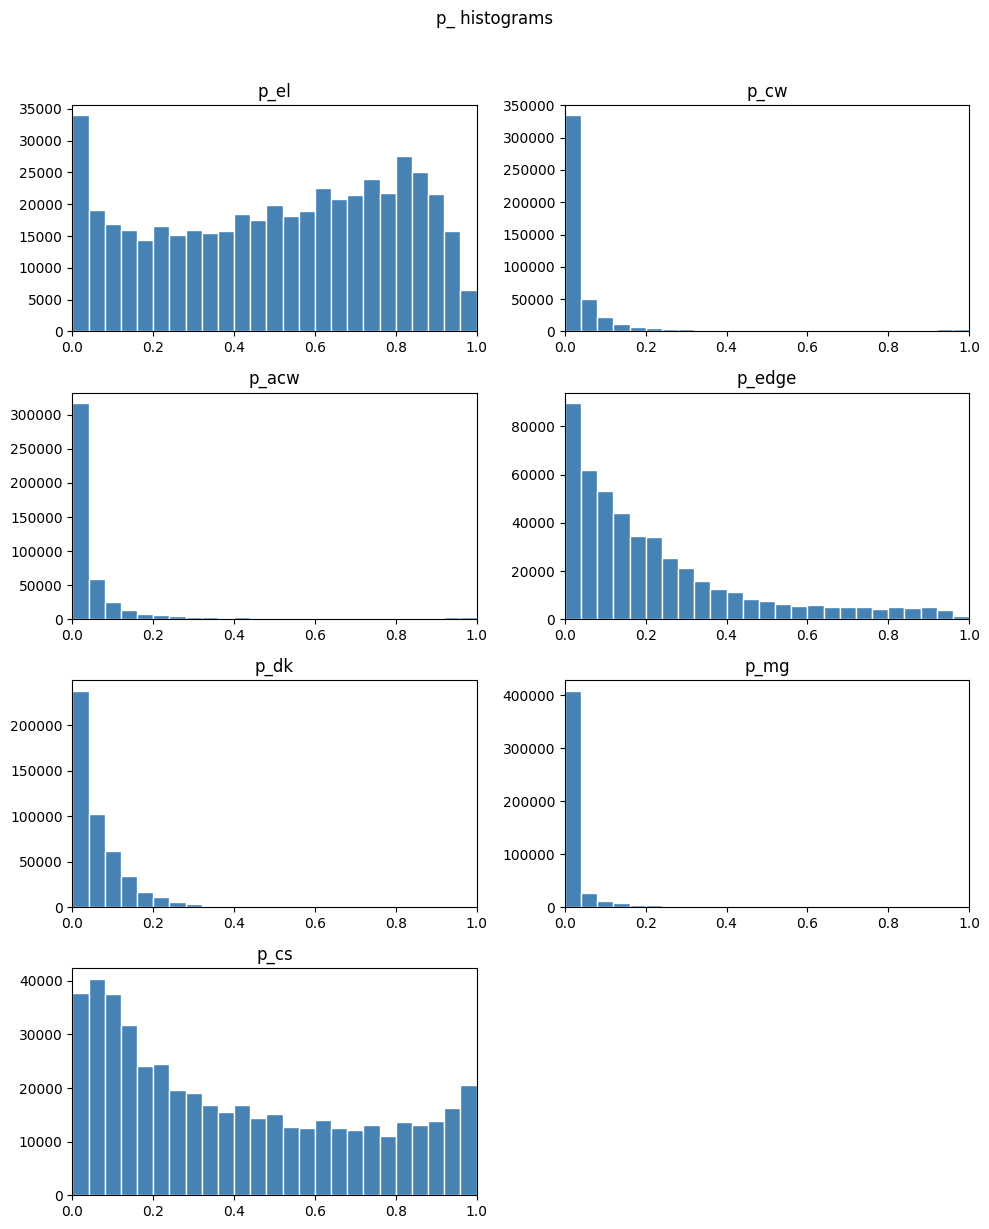

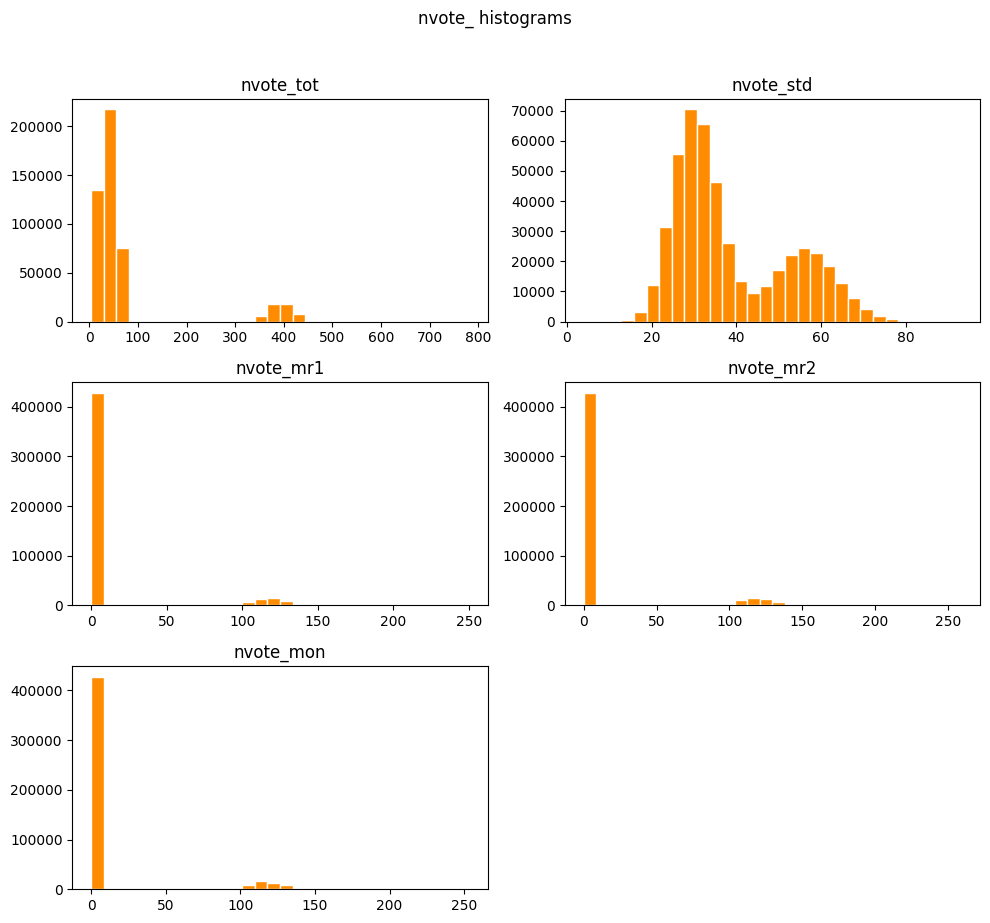

In [4]:
# Histograms for all `p_` and `nvote_` columns (galaxies only), two per row

p_cols = [c for c in galaxy_rows.columns if c.startswith("p_")]
nvote_cols = [c for c in galaxy_rows.columns if c.startswith("nvote_")]


# Helper to plot a list of columns in a 2-per-row grid
def plot_cols_two_per_row(cols, process_fn, title, color):
    if not cols:
        print(f"No columns to plot for {title}.")
        return
    n = len(cols)
    rows = math.ceil(n / 2)
    fig, axes = plt.subplots(rows, 2, figsize=(10, 3.0 * rows), squeeze=False)
    axes_flat = axes.ravel()
    for i, col in enumerate(cols):
        ax = axes_flat[i]
        vals = process_fn(galaxy_rows[col].dropna())
        ax.hist(
            vals,
            bins=25 if title.startswith("p_") else 30,
            color=color,
            edgecolor="white",
        )
        ax.set_title(col)
        if title.startswith("p_"):
            ax.set_xlim(0, 1)
    # hide any extra axes
    for j in range(len(cols), len(axes_flat)):
        axes_flat[j].axis("off")
    fig.suptitle(title, y=1.02)
    plt.tight_layout()
    plt.show()


# Define processors
p_process = lambda s: s[(s >= 0.0) & (s <= 1.0)]
nvote_process = lambda s: s[s >= 0]

plot_cols_two_per_row(p_cols, p_process, title="p_ histograms", color="steelblue")
plot_cols_two_per_row(
    nvote_cols, nvote_process, title="nvote_ histograms", color="darkorange"
)


In [ ]:
# Prepare and (optionally) download Legacy Survey cutouts for valid galaxies

# Build mask of valid galaxies
valid_mask = (
    galaxy_rows["p_el"].between(0.0, 1.0)
    & galaxy_rows["nvote_tot"].notna()
    & (galaxy_rows["nvote_tot"] >= 0)
    & ((galaxy_rows["nvote_tot"] % 1) == 0)
    & galaxy_rows["ra"].notna()
    & galaxy_rows["dec"].notna()
    & galaxy_rows["objid"].notna()
)

valid_galaxies = galaxy_rows.loc[valid_mask].copy()

# Prepare identifiers and coordinates
# Use `objid` as the filename-friendly target id
targetid = valid_galaxies["objid"].astype("Int64").astype(str).values
ra = valid_galaxies["ra"].astype(float).values
dec = valid_galaxies["dec"].astype(float).values

# Ensure output directory exists
os.makedirs("../input/images", exist_ok=True)

# Limit downloads for now
num_to_download = 10  # set to 10 later to fetch the first 10
max_first = 10
n = min(num_to_download, max_first, len(targetid))

print(
    f"Valid galaxies available: {len(targetid)}. Planned downloads (first {max_first}): {n}"
)

for i in range(n):
    cmd = (
        "wget -P . -O "
        + "../input/images/"
        + str(targetid[i])
        + ".jpeg "
        + "https://www.legacysurvey.org/viewer/jpeg-cutout?ra="
        + str(ra[i])
        + "\\&dec="
        + str(dec[i])
        + "\\&layer=ls-dr9\\&pixscale=0.1\\&bands=grz"
    )
    print(cmd)
    os.system(cmd)

if n == 0:
    print(
        "Download limit is 0. No files downloaded. Increase `num_to_download` to proceed."
    )


Valid galaxies available: 479135. Planned downloads (first 10): 0
Download limit is 0. No files downloaded. Increase `num_to_download` to proceed.


In [16]:
urls = []
urls = [
    f"url = https://www.legacysurvey.org/viewer/jpeg-cutout?ra={ra[i]}&dec={dec[i]}&layer=ls-dr9&pixscale=0.1&bands=grz\noutput = {targetid[i]}.jpeg\n"
    for i in range(len(targetid))
]

with open("urls.txt", "w") as file:
    file.writelines(urls)

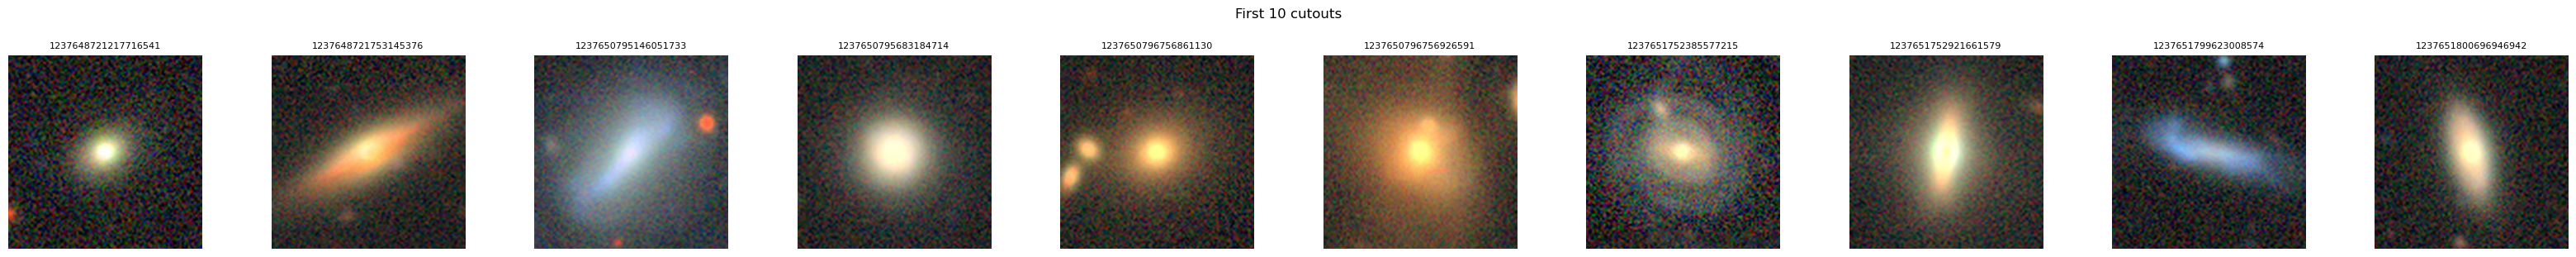

In [ ]:
# Visualize the first 10 downloaded cutout images
from pathlib import Path

img_dir = Path("../input/images")
jpeg_files = sorted(img_dir.glob("*.jpeg"))

if len(jpeg_files) == 0:
    print("No images found in ../input/images.")
else:
    files = jpeg_files[:10]
    cols = len(files)
    fig, axes = plt.subplots(1, cols, figsize=(3 * cols + 2, 3))
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])
    for ax, f in zip(axes, files):
        img = plt.imread(str(f))
        ax.imshow(img)
        ax.set_title(f.stem, fontsize=8)
        ax.axis("off")
    plt.suptitle("First 10 cutouts", y=1.02)
    plt.tight_layout()
    plt.show()

In [18]:
# Download first 10 SDSS spectra (DR19) using wget
# Requires `valid_galaxies` from the earlier cell and columns: plate, mjd, fiberid

# Build mask requiring spectra identifiers
spec_mask = (
    valid_galaxies["plate"].notna()
    & valid_galaxies["mjd"].notna()
    & valid_galaxies["fiberid"].notna()
)

spec_rows = valid_galaxies.loc[spec_mask].copy()

# Cast and zero-pad
plate = spec_rows["plate"].astype("Int64").astype(str).str.zfill(4).values
mjd = spec_rows["mjd"].astype("Int64").astype(str).values
fiberid = spec_rows["fiberid"].astype("Int64").astype(str).str.zfill(4).values

# Ensure destination dir exists
os.makedirs("../input/spectra", exist_ok=True)

num_to_download = 1
max_first = 10
n_spec = min(num_to_download, max_first, len(plate))
print(
    f"Valid spectra rows available: {len(plate)}. Planned spectra downloads (first {max_first}): {n_spec}"
)

base = "https://data.sdss.org/sas/dr19/sdss/spectro/redux/26/spectra/lite/"

for i in range(n_spec):
    url = (
        base
        + plate[i]
        + "/spec-"
        + plate[i]
        + "-"
        + mjd[i]
        + "-"
        + fiberid[i]
        + ".fits"
    )
    cmd = "wget -q -P ../input/spectra/ " + url
    rc = os.system(cmd)
    status = "ok" if rc == 0 else f"fail({rc})"
    print(f"[{i + 1}/{n_spec}] {url} -> {status}")

if n_spec == 0:
    print("No spectra downloaded (n_spec == 0). Increase `num_to_download` if needed.")


Valid spectra rows available: 479135. Planned spectra downloads (first 10): 1
[1/1] https://data.sdss.org/sas/dr19/sdss/spectro/redux/26/spectra/lite/0335/spec-0335-52000-0244.fits -> fail(2048)


In [20]:
spec_urls = []
spec_urls = [
    f"url = https://data.sdss.org/sas/dr19/spectro/sdss/redux/26/spectra/lite/{plate[i]}/spec-{plate[i]}-{mjd[i]}-{fiberid[i]}.fits\noutput = spec-{plate[i]}-{mjd[i]}-{fiberid[i]}.fits\n"
    for i in range(len(plate))
]

with open("spectra_urls.txt", "w") as file:
    file.writelines(spec_urls)


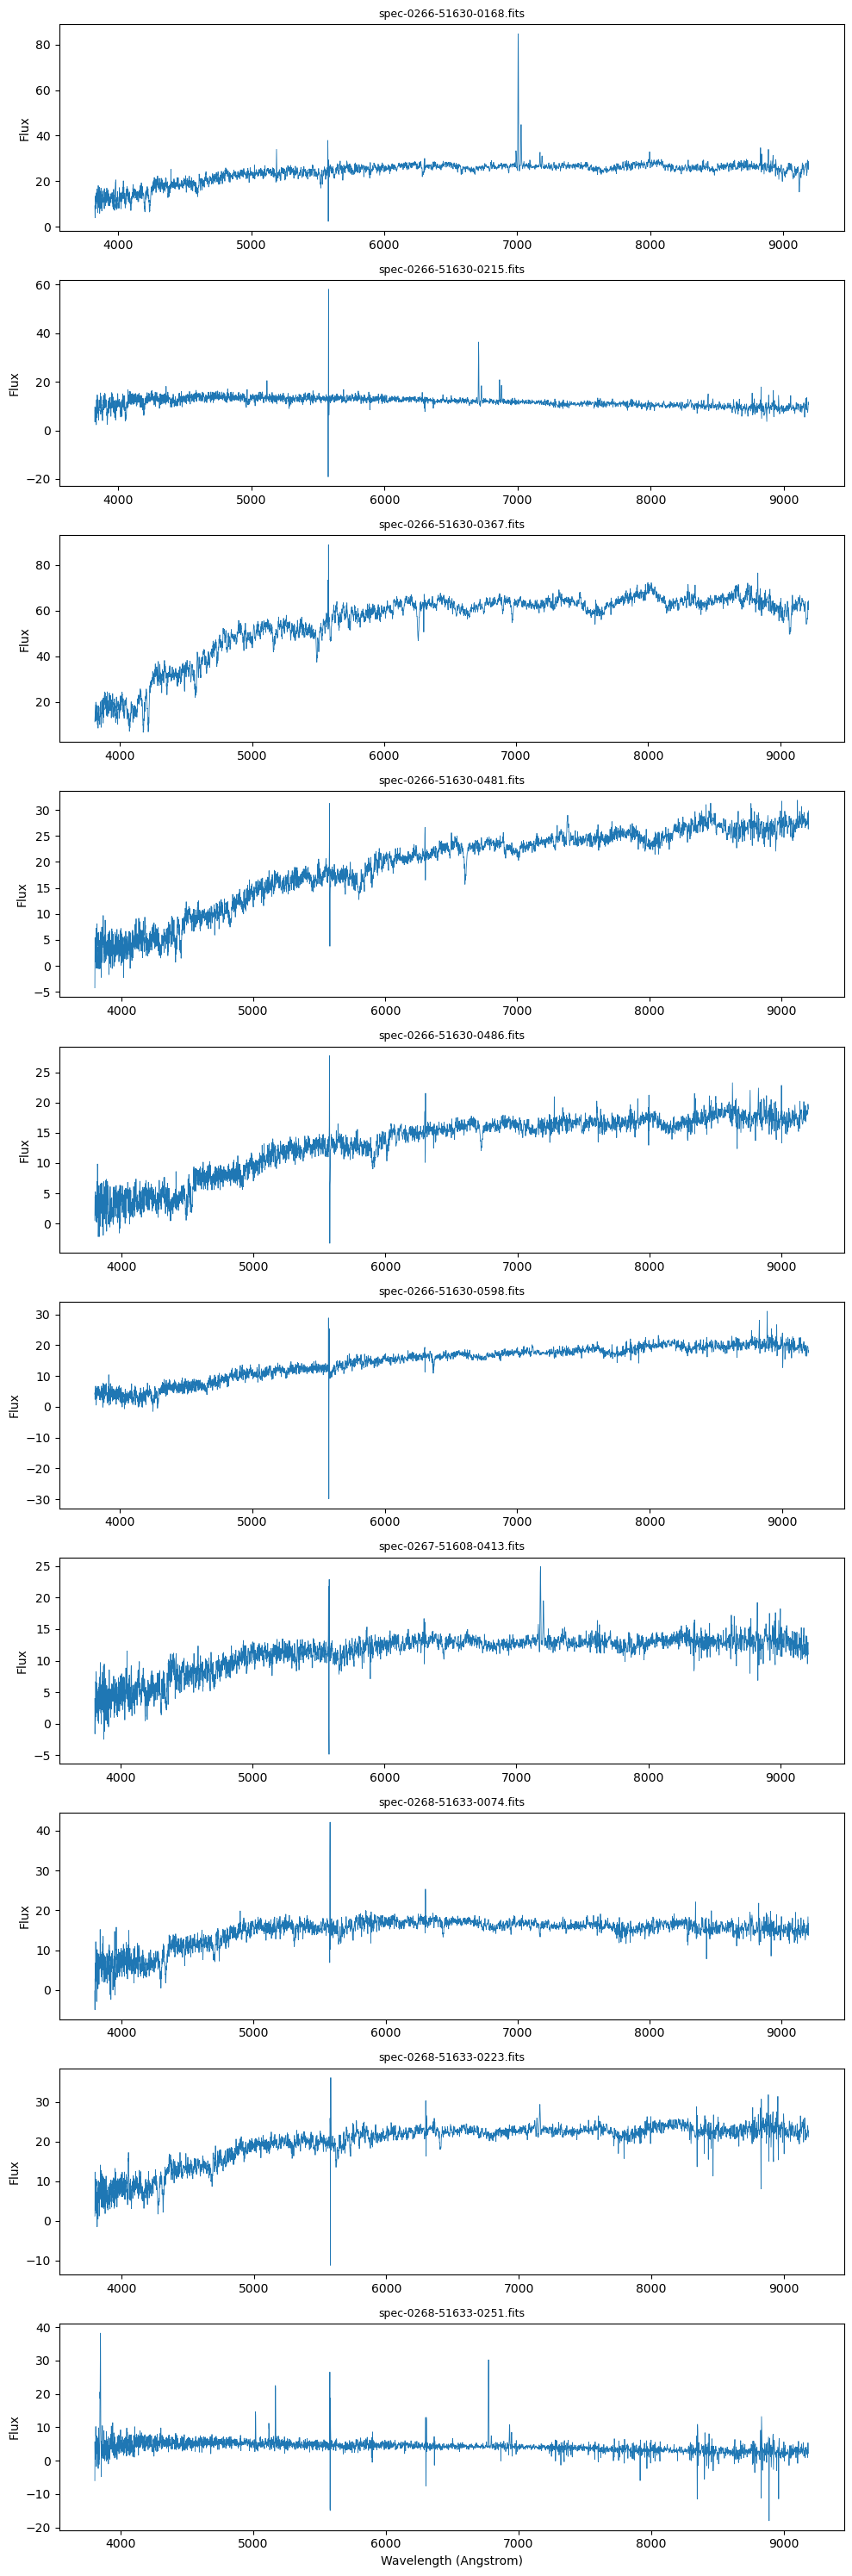

In [ ]:
# Visualize a few downloaded spectra (reads FITS and plots flux vs wavelength)
try:
    from astropy.io import fits
except ImportError:
    raise ImportError(
        "astropy is required for reading FITS. Install with `pip install astropy` and re-run this cell."
    )

spec_dir = Path("../input/spectra")
fit_files = sorted(spec_dir.glob("*.fits"))


def read_spectrum_fits(path: Path):
    with fits.open(str(path), memmap=False) as hdul:
        wavelength = None
        flux = None
        ivar = None
        # Try table HDUs with 'loglam'/'flux' columns
        for hdu in hdul:
            data = getattr(hdu, "data", None)
            cols = []
            try:
                cols = (
                    [c.lower() for c in hdu.columns.names]
                    if hasattr(hdu, "columns")
                    else []
                )
            except Exception:
                cols = []
            if data is not None and cols:
                get = (
                    lambda name: data[name]
                    if name in data.names
                    else data[name.upper()]
                )
                if ("loglam" in cols or "LOGLAM" in getattr(hdu, "columns", [])) and (
                    "flux" in cols or "FLUX" in getattr(hdu, "columns", [])
                ):
                    loglam = get("loglam") if "loglam" in cols else get("LOGLAM")
                    flux = np.asarray(
                        get("flux") if "flux" in cols else get("FLUX"), dtype=float
                    )
                    if "ivar" in cols or "IVAR" in getattr(hdu, "columns", []):
                        ivar = np.asarray(
                            get("ivar") if "ivar" in cols else get("IVAR"), dtype=float
                        )
                    wavelength = np.power(10.0, np.asarray(loglam, dtype=float))
                    break
        # Fallback: image HDU with COEFF0/COEFF1 and 1D flux
        if wavelength is None:
            for hdu in hdul:
                data = getattr(hdu, "data", None)
                if isinstance(data, np.ndarray) and data.ndim == 1:
                    hdr = hdu.header
                    if "COEFF0" in hdr and "COEFF1" in hdr:
                        n = data.shape[0]
                        pix = np.arange(n, dtype=float)
                        wavelength = 10.0 ** (hdr["COEFF0"] + hdr["COEFF1"] * pix)
                        flux = data.astype(float)
                        ivar = None
                        break
        return wavelength, flux, ivar


if len(fit_files) == 0:
    print("No FITS spectra found in ../input/spectra.")
else:
    k = min(10, len(fit_files))
    files = fit_files[:k]
    fig, axes = plt.subplots(k, 1, figsize=(10, 3.0 * k), sharex=False)
    if k == 1:
        axes = [axes]
    for ax, f in zip(axes, files):
        wave, flux, ivar = read_spectrum_fits(f)
        if wave is None or flux is None:
            ax.text(0.5, 0.5, f"Unable to read {f.name}", ha="center", va="center")
            ax.axis("off")
            continue
        mask = np.isfinite(wave) & np.isfinite(flux)
        wave = wave[mask]
        flux = flux[mask]
        ax.plot(wave, flux, lw=0.6)
        ax.set_ylabel("Flux")
        ax.set_title(f.name, fontsize=9)
    axes[-1].set_xlabel("Wavelength (Angstrom)")
    plt.tight_layout()
    plt.show()
